In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
batch_size = 32
img_height = 128
img_width = 128

In [3]:
# To visualize the loops
from tqdm import tqdm
root_path = "../ai_project/dataset"

closed_fist = pd.DataFrame({"filepath":[os.path.join(root_path,"Closed_fist",os.listdir("../ai_project/dataset/Closed_fist")[i]) for i in tqdm(range(150),position=0,leave=True)],'label':1})
finger_guns = pd.DataFrame({"filepath":[os.path.join(root_path,"Finger_guns",os.listdir("../ai_project/dataset/Finger_guns")[i]) for i in tqdm(range(150),position=0,leave=True)],'label':2})
open_palm = pd.DataFrame({"filepath":[os.path.join(root_path,"Open_palm",os.listdir("../ai_project/dataset/Open_palm")[i]) for i in tqdm(range(150),position=0,leave=True)],'label':3})
peace_sign = pd.DataFrame({"filepath":[os.path.join(root_path,"Peace_sign",os.listdir("../ai_project/dataset/Peace_sign")[i]) for i in tqdm(range(150),position=0,leave=True)],'label':4})
pinky = pd.DataFrame({"filepath":[os.path.join(root_path,"Pinky",os.listdir("../ai_project/dataset/Pinky")[i]) for i in tqdm(range(150),position=0,leave=True)],'label':5})

pointing = pd.DataFrame({"filepath":[os.path.join(root_path,"Pointing",os.listdir("../ai_project/dataset/Pointing")[i]) for i in tqdm(range(150),position=0,leave=True)],'label':6})
rocknroll = pd.DataFrame({"filepath":[os.path.join(root_path,"Rocknroll",os.listdir("../ai_project/dataset/Rocknroll")[i]) for i in tqdm(range(150),position=0,leave=True)],'label':7})
spiderman = pd.DataFrame({"filepath":[os.path.join(root_path,"Spiderman",os.listdir("../ai_project/dataset/Spiderman")[i]) for i in tqdm(range(150),position=0,leave=True)],'label':8})
spock = pd.DataFrame({"filepath":[os.path.join(root_path,"Spock",os.listdir("../ai_project/dataset/Spock")[i]) for i in tqdm(range(150),position=0,leave=True)],'label':9})
thumbs_up = pd.DataFrame({"filepath":[os.path.join(root_path,"Thumbs_up",os.listdir("../ai_project/dataset/Thumbs_up")[i]) for i in tqdm(range(150),position=0,leave=True)],'label':10})

df = pd.concat([closed_fist,finger_guns,open_palm,peace_sign,pinky,pointing,rocknroll,spiderman,spock,thumbs_up],axis=0)
df['label'] = df['label'].astype(str)
df.head()

100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 2719.37it/s]


,filepath,label
0,../ai_project/dataset\Closed_fist\Closed_fist ...,1
1,../ai_project/dataset\Closed_fist\Closed_fist ...,1
2,../ai_project/dataset\Closed_fist\Closed_fist ...,1
3,../ai_project/dataset\Closed_fist\Closed_fist ...,1
4,../ai_project/dataset\Closed_fist\Closed_fist ...,1


In [4]:
from sklearn.utils import shuffle

df = shuffle(df)
df.reset_index(drop=True,inplace=True)
df.head()

,filepath,label
0,../ai_project/dataset\Thumbs_up\Thumbs_up (164...,10
1,../ai_project/dataset\Rocknroll\Rocknroll (14)...,7
2,../ai_project/dataset\Finger_guns\Finger_guns ...,2
3,../ai_project/dataset\Pointing\Pointing (202).jpg,6
4,../ai_project/dataset\Spock\Spock (171).JPG,9


In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  root_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4358 files belonging to 10 classes.
Using 3487 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  root_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4358 files belonging to 10 classes.
Using 871 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['Closed_fist', 'Finger_guns', 'Open_palm', 'Peace_sign', 'Pinky', 'Pointing', 'Rocknroll', 'Spiderman', 'Spock', 'Thumbs_up']


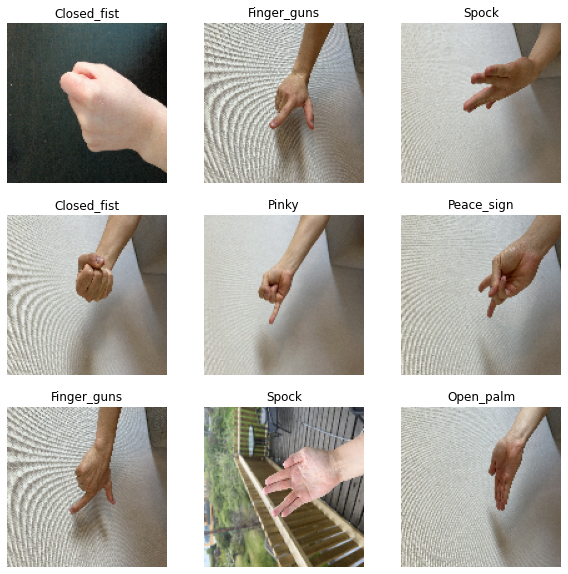

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`
print(np.min(first_image), np.max(first_image))

0.02567402 0.9514707


In [13]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

In [16]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
109/109 [==============================] - 15s 137ms/step - loss: 1.8821 - accuracy: 0.3450 - val_loss: 0.9079 - val_accuracy: 0.7141
Epoch 2/10
109/109 [==============================] - 9s 86ms/step - loss: 0.4941 - accuracy: 0.8509 - val_loss: 0.3735 - val_accuracy: 0.8714
Epoch 3/10
109/109 [==============================] - 9s 85ms/step - loss: 0.2541 - accuracy: 0.9292 - val_loss: 0.1907 - val_accuracy: 0.9392
Epoch 4/10
109/109 [==============================] - 9s 87ms/step - loss: 0.0772 - accuracy: 0.9773 - val_loss: 0.0740 - val_accuracy: 0.9793
Epoch 5/10
109/109 [==============================] - 9s 85ms/step - loss: 0.0308 - accuracy: 0.9931 - val_loss: 0.0557 - val_accuracy: 0.9816
Epoch 6/10
109/109 [==============================] - 9s 85ms/step - loss: 0.0512 - accuracy: 0.9882 - val_loss: 0.1514 - val_accuracy: 0.9529
Epoch 7/10
109/109 [==============================] - 9s 87ms/step - loss: 0.0548 - accuracy: 0.9862 - val_loss: 0.0500 - val_accuracy: 0.98

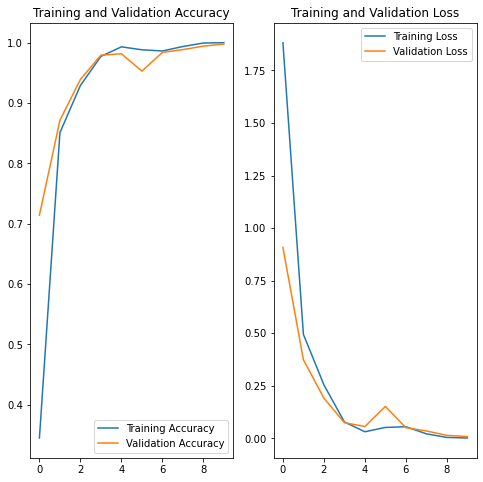

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

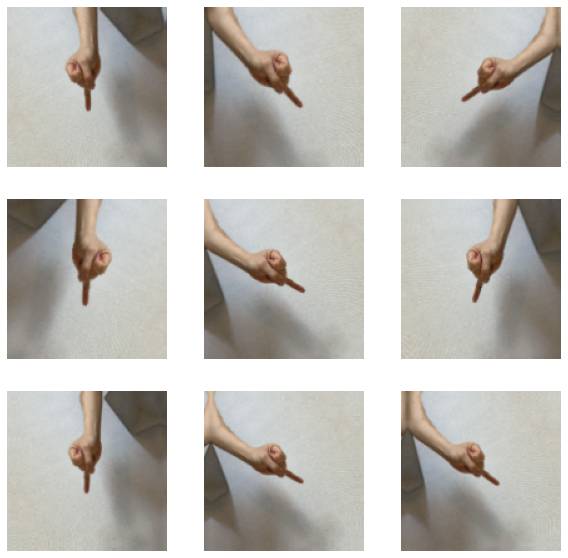

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [20]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                  

In [23]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
109/109 [==============================] - 11s 97ms/step - loss: 2.1719 - accuracy: 0.1924 - val_loss: 1.7880 - val_accuracy: 0.3215
Epoch 2/15
109/109 [==============================] - 10s 95ms/step - loss: 1.6986 - accuracy: 0.3785 - val_loss: 1.4665 - val_accuracy: 0.4799
Epoch 3/15
109/109 [==============================] - 11s 97ms/step - loss: 1.4008 - accuracy: 0.5050 - val_loss: 1.2181 - val_accuracy: 0.5763
Epoch 4/15
109/109 [==============================] - 11s 98ms/step - loss: 1.1678 - accuracy: 0.6005 - val_loss: 0.7753 - val_accuracy: 0.7394
Epoch 5/15
109/109 [==============================] - 11s 100ms/step - loss: 0.8382 - accuracy: 0.7192 - val_loss: 1.0746 - val_accuracy: 0.6223
Epoch 6/15
109/109 [==============================] - 11s 99ms/step - loss: 0.7001 - accuracy: 0.7571 - val_loss: 0.8882 - val_accuracy: 0.7141
Epoch 7/15
109/109 [==============================] - 11s 100ms/step - loss: 0.5364 - accuracy: 0.8208 - val_loss: 1.2021 - val_accurac

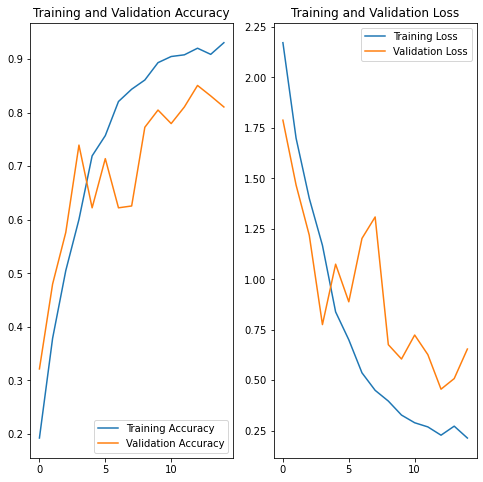

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

(128, 128, 3)


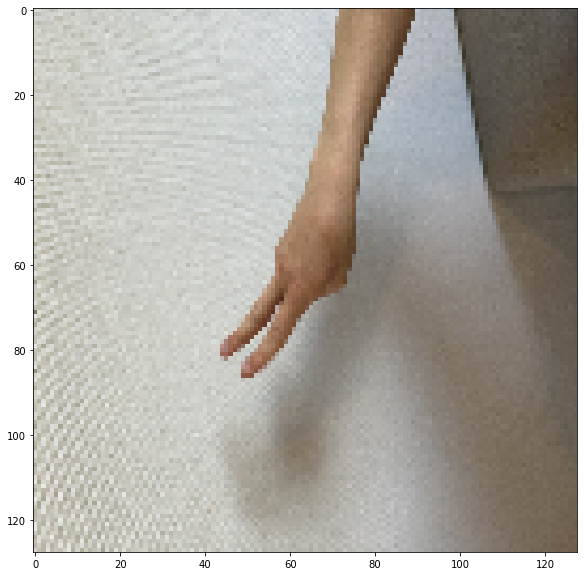

Label:  3
(128, 128, 3)


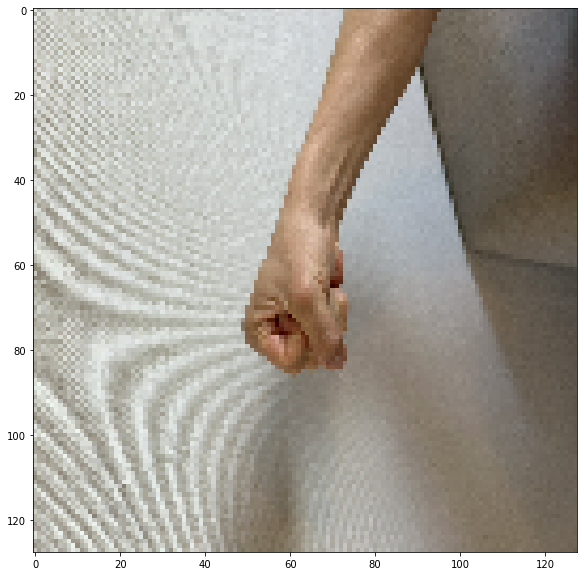

Label:  0
(128, 128, 3)


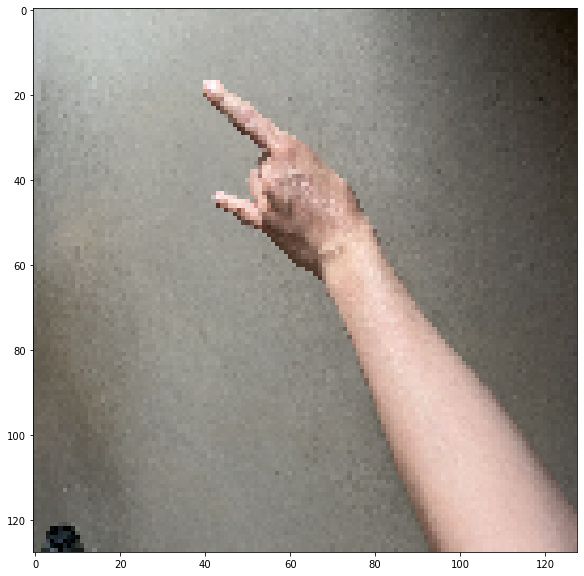

Label:  6
(128, 128, 3)


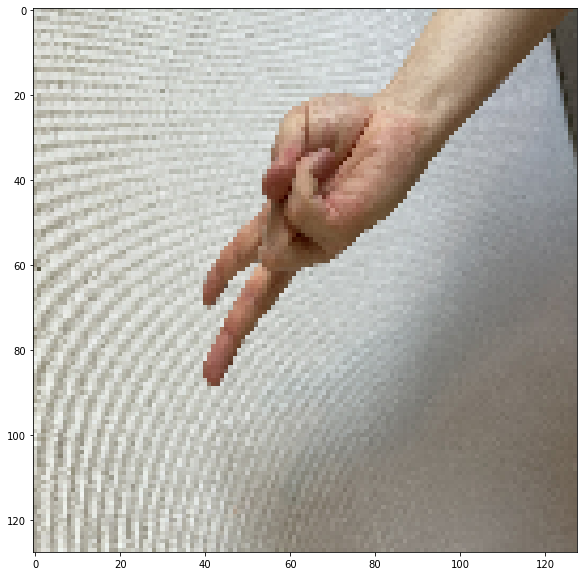

Label:  3
(128, 128, 3)


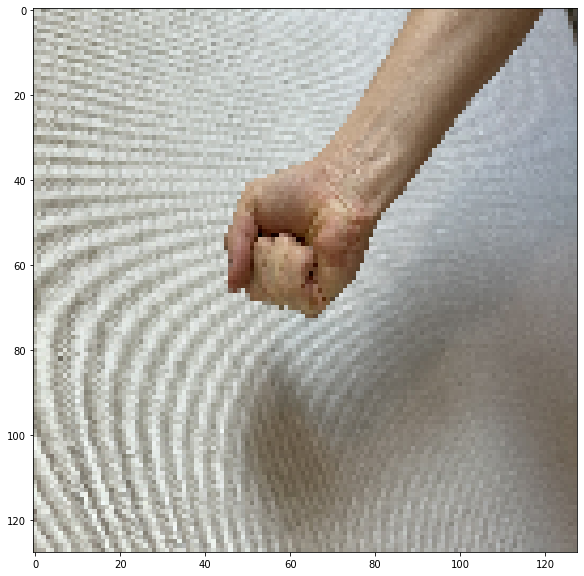

Label:  0


In [95]:
t_x, t_y = next(iter(normalized_ds))
for batch in normalized_ds:
    images = batch[0]
    labels = batch[1]
    for i in range(5):
        plt.figure(figsize=(20,10))
        plt.imshow(images[i])
        print(images[i].shape)
        plt.show()
        print("Label: ", labels[i].numpy())
    break
    
#get list of labels for the t_x images
#t_y = t_y.numpy()    

In [96]:
model.fit(train_ds, epochs=5, batch_size=64, verbose=2, validation_data=(t_x, t_y))

Epoch 1/5
109/109 - 10s - loss: 0.1446 - accuracy: 0.9518 - val_loss: 32.7366 - val_accuracy: 0.0938 - 10s/epoch - 92ms/step
Epoch 2/5
109/109 - 10s - loss: 0.1439 - accuracy: 0.9541 - val_loss: 33.5581 - val_accuracy: 0.0938 - 10s/epoch - 93ms/step
Epoch 3/5
109/109 - 10s - loss: 0.1881 - accuracy: 0.9352 - val_loss: 28.2161 - val_accuracy: 0.0938 - 10s/epoch - 94ms/step
Epoch 4/5
109/109 - 10s - loss: 0.1301 - accuracy: 0.9544 - val_loss: 28.0881 - val_accuracy: 0.0938 - 10s/epoch - 92ms/step
Epoch 5/5
109/109 - 10s - loss: 0.1781 - accuracy: 0.9415 - val_loss: 22.9423 - val_accuracy: 0.0938 - 10s/epoch - 94ms/step


In [97]:
test_loss, test_acc = model.evaluate(t_x, t_y)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

1/1 [==============================] - 0s 28ms/step - loss: 22.9423 - accuracy: 0.0938
Test accuracy: 9.38%


In [101]:
pred=model.predict(t_x)
np.argmax(pred[0]), t_y[0] 


(5, <tf.Tensor: shape=(), dtype=int32, numpy=2>)